# 互评作业二：频繁模式及关联规则挖掘
**github**：https://github.com/ckqaq/dm2021_hw/tree/main/assignment2

本次作业采用数据集wine进行分析。
## 1. 转换数据
通过数据转换将数据转成适合关联规则挖掘的形式，主要任务包括：
- 删除缺失值
- 对数值属性分层
- 选出points,price,country，winery四个属性进行下一步分析

In [1]:
import numpy as np 
import pandas as pd

In [2]:
# 导入数据并去除缺失值
data = pd.read_csv('./wine/winemag-data-130k-v2.csv')
data =data.dropna()

In [3]:
# 将其中的数值属性离散化
number_data = ['points','price']
data[number_data].describe()

,points,price
count,22387.000000,22387.000000
mean,89.537812,41.465404
std,2.809306,29.379374
min,80.000000,4.000000
25%,88.000000,25.000000
50%,90.000000,36.000000
75%,92.000000,50.000000
max,100.000000,2013.000000


In [4]:
# 根据五数概括给数值数据分层
# 每个属性分4个层。
# point
bin = [0,88,90,92,100]
data['points'] = pd.cut(data['points'],bin)
data['points'] = data['points'].astype('str')
# price
bin = [0,25,36,50,2013]
data['price'] = pd.cut(data['price'],bin)
data['price'] = data['price'].astype('str')

In [5]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,"(0, 88]","(50, 2013]",Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,"(0, 88]","(0, 25]",California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,"(0, 88]","(0, 25]",California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,"(0, 88]","(50, 2013]",California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
35,35,US,As with many of the Erath 2010 vineyard design...,Hyland,"(0, 88]","(36, 50]",Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


In [6]:
# 选取points,price,country以及winery进行挖掘
data = data[['points','price','country','winery']]
data.head(5)

,points,price,country,winery
4,"(0, 88]","(50, 2013]",US,Sweet Cheeks
10,"(0, 88]","(0, 25]",US,Kirkland Signature
23,"(0, 88]","(0, 25]",US,Bianchi
25,"(0, 88]","(50, 2013]",US,Castello di Amorosa
35,"(0, 88]","(36, 50]",US,Erath



## 2. 找出频繁项集
- 使用Apriori方法，通过计算概率得出关联的组合。

In [7]:
# 统计一级候选项集
def createC1(data):
    c1 = []
    for thing in np.array(data):
        for item in thing:
            if [item] not in c1:
                c1.append([item])
    c1.sort()
    return list(map(frozenset,c1))

# 统计K级候选项集的出现次数，返回k级候选项集和支持度
def scanD( D, Ck, minSupport ):
    ssCnt = {}
    for tid in D:
        if Ck is not None:
            for can in Ck:
                if can.issubset(tid):
                    ssCnt[can] = ssCnt.get(can, 0) + 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key] / numItems
        if support >= minSupport:
            retList.insert( 0, key )
            supportData[key] = support
    return retList, supportData

def aprioriR(Lk, k):
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            L1 = list( Lk[i])[: k - 2]
            L2 = list( Lk[j])[: k - 2]
            L1.sort()
            L2.sort()    
            if L1==L2:
                retList.append( Lk[i] | Lk[j] ) 
    return retList

def apriori(dataSet, minSupport = 0.5):
    C1 = createC1(dataSet)
    D =list(map(set, dataSet))
    L1, suppData = scanD(D, C1, minSupport)
    L = [L1]
    k = 2
    
    while (len(L[k - 2]) > 0):# 在k-1级基础上生成k级候选集
        Ck = aprioriR(L[k - 2], k)
        Lk, supK = scanD(D, Ck, minSupport)
        suppData.update(supK)
        L.append(Lk)
        k += 1
    return L, suppData

In [8]:
# 频繁项集
newData = list(map(set,np.array(data)))
L, suppData = apriori(newData, 0.05)# 最小支持度为0.5
L

[[frozenset({'(92, 100]'}),
  frozenset({'(88, 90]'}),
  frozenset({'(90, 92]'}),
  frozenset({'(25, 36]'}),
  frozenset({'(36, 50]'}),
  frozenset({'(0, 25]'}),
  frozenset({'US'}),
  frozenset({'(50, 2013]'}),
  frozenset({'(0, 88]'})],
 [frozenset({'(50, 2013]', '(92, 100]'}),
  frozenset({'(92, 100]', 'US'}),
  frozenset({'(36, 50]', '(88, 90]'}),
  frozenset({'(0, 25]', '(88, 90]'}),
  frozenset({'(25, 36]', '(88, 90]'}),
  frozenset({'(88, 90]', 'US'}),
  frozenset({'(36, 50]', '(90, 92]'}),
  frozenset({'(25, 36]', '(90, 92]'}),
  frozenset({'(50, 2013]', '(90, 92]'}),
  frozenset({'(90, 92]', 'US'}),
  frozenset({'(0, 88]', '(25, 36]'}),
  frozenset({'(25, 36]', 'US'}),
  frozenset({'(0, 88]', '(36, 50]'}),
  frozenset({'(36, 50]', 'US'}),
  frozenset({'(0, 25]', '(0, 88]'}),
  frozenset({'(0, 25]', 'US'}),
  frozenset({'(0, 88]', 'US'}),
  frozenset({'(50, 2013]', 'US'})],
 [frozenset({'(50, 2013]', '(92, 100]', 'US'}),
  frozenset({'(36, 50]', '(88, 90]', 'US'}),
  frozenset(

## 3. 导出关联规则，计算支持度和置信度

In [9]:
for tmp, num in suppData.items():
    print(tmp, ':', num)

frozenset({'(0, 88]'}) : 0.3699468441506231
frozenset({'(50, 2013]'}) : 0.23187564211372672
frozenset({'US'}) : 1.0
frozenset({'(0, 25]'}) : 0.2844061285567517
frozenset({'(36, 50]'}) : 0.25318265064546386
frozenset({'(25, 36]'}) : 0.23053557868405772
frozenset({'(90, 92]'}) : 0.24514227006744985
frozenset({'(88, 90]'}) : 0.23719122705141377
frozenset({'(92, 100]'}) : 0.14771965873051324
frozenset({'US', '(50, 2013]'}) : 0.23187564211372672
frozenset({'US', '(0, 88]'}) : 0.3699468441506231
frozenset({'US', '(0, 25]'}) : 0.2844061285567517
frozenset({'(0, 88]', '(0, 25]'}) : 0.18064055031938178
frozenset({'US', '(36, 50]'}) : 0.25318265064546386
frozenset({'(0, 88]', '(36, 50]'}) : 0.06222361191763077
frozenset({'(25, 36]', 'US'}) : 0.23053557868405772
frozenset({'(25, 36]', '(0, 88]'}) : 0.09501049716353241
frozenset({'US', '(90, 92]'}) : 0.24514227006744985
frozenset({'(50, 2013]', '(90, 92]'}) : 0.07450752668959663
frozenset({'(25, 36]', '(90, 92]'}) : 0.055165944521374015
frozenset(

In [10]:
#输入频繁项集列表、频繁项集的支持度字典、最小置信度
#输出包含置信度的规则列表
def generateRules(L, supportData, minConf=0.5):
    bigRuleList = []
    for i in range(1, len(L)):
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]   #规则后件集合
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList

#生成候选规则集合
def calcConf(freqSet, H, supportData, brl, minConf=0.5):
    prunedH = []
    for conseq in H:
        conf = supportData[freqSet]/supportData[freqSet-conseq]   #集合相减
        if conf >= minConf:
            print(f'{freqSet-conseq} --> {conseq} conf:{conf}'+ "  support: "+ str(supportData[freqSet]))
            brl.append((freqSet-conseq, conseq, conf, supportData[freqSet]))
            prunedH.append(conseq)
    return prunedH

#对规则进行评估
def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.5):
    m = len(H[0])
    if (len(freqSet) > (m + 1)):
        Hmp1 = aprioriR(H, m+1)
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        if (len(Hmp1) > 1):
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

In [11]:
rules = generateRules(L, suppData, minConf=0.05)

frozenset({'(50, 2013]'}) --> frozenset({'(92, 100]'}) conf:0.358312463879792  support: 0.08308393263947828
frozenset({'(92, 100]'}) --> frozenset({'(50, 2013]'}) conf:0.5624433020864833  support: 0.08308393263947828
frozenset({'US'}) --> frozenset({'(92, 100]'}) conf:0.14771965873051324  support: 0.14771965873051324
frozenset({'(92, 100]'}) --> frozenset({'US'}) conf:1.0  support: 0.14771965873051324
frozenset({'(88, 90]'}) --> frozenset({'(36, 50]'}) conf:0.2621468926553672  support: 0.0621789431366418
frozenset({'(36, 50]'}) --> frozenset({'(88, 90]'}) conf:0.24558927311220893  support: 0.0621789431366418
frozenset({'(88, 90]'}) --> frozenset({'(0, 25]'}) conf:0.28549905838041434  support: 0.06771787197927369
frozenset({'(0, 25]'}) --> frozenset({'(88, 90]'}) conf:0.23810271713522854  support: 0.06771787197927369
frozenset({'(88, 90]'}) --> frozenset({'(25, 36]'}) conf:0.2743879472693032  support: 0.06508241390092465
frozenset({'(25, 36]'}) --> frozenset({'(88, 90]'}) conf:0.2823096

## 4. 对规则进行评价
- 使用lift及全置信度对关联规则评价

In [12]:
rules[0],suppData[rules[0][0]],suppData[rules[0][1]]

((frozenset({'(50, 2013]'}),
  frozenset({'(92, 100]'}),
  0.358312463879792,
  0.08308393263947828),
 0.23187564211372672,
 0.14771965873051324)

In [13]:
def getlift(rules, suppData):
    lift = []
    for rule in rules:
        freqSet_conseq = rule[0]
        conseq = rule[1]
        lift_val = float(rule[3]) / (float(suppData[rule[0]])*float(suppData[rule[1]]))
        lift.append([freqSet_conseq, conseq, lift_val])
    return lift

In [14]:
lift = getlift(rules, suppData)
lift

[[frozenset({'(50, 2013]'}), frozenset({'(92, 100]'}), 2.4256247743806783],
 [frozenset({'(92, 100]'}), frozenset({'(50, 2013]'}), 2.4256247743806783],
 [frozenset({'US'}), frozenset({'(92, 100]'}), 1.0],
 [frozenset({'(92, 100]'}), frozenset({'US'}), 1.0],
 [frozenset({'(88, 90]'}), frozenset({'(36, 50]'}), 1.0354062254544296],
 [frozenset({'(36, 50]'}), frozenset({'(88, 90]'}), 1.0354062254544296],
 [frozenset({'(88, 90]'}), frozenset({'(0, 25]'}), 1.0038428490595783],
 [frozenset({'(0, 25]'}), frozenset({'(88, 90]'}), 1.0038428490595783],
 [frozenset({'(88, 90]'}), frozenset({'(25, 36]'}), 1.1902195263549487],
 [frozenset({'(25, 36]'}), frozenset({'(88, 90]'}), 1.1902195263549487],
 [frozenset({'(88, 90]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(88, 90]'}), 1.0],
 [frozenset({'(90, 92]'}), frozenset({'(36, 50]'}), 1.35879501513278],
 [frozenset({'(36, 50]'}), frozenset({'(90, 92]'}), 1.35879501513278],
 [frozenset({'(90, 92]'}), frozenset({'(25, 36]'}), 0.976146

In [15]:
def all_confidence(rules,suppData):
    num = []
    for rule in rules:
        A = rule[0]
        B = rule[1]
        k = suppData[B]/max(suppData[A],suppData[B-A])
        num.append([A, B, k])
    return num

In [16]:
all_conf = all_confidence(rules, suppData)
all_conf

[[frozenset({'(50, 2013]'}), frozenset({'(92, 100]'}), 0.6370641494895011],
 [frozenset({'(92, 100]'}), frozenset({'(50, 2013]'}), 1.0],
 [frozenset({'US'}), frozenset({'(92, 100]'}), 0.14771965873051324],
 [frozenset({'(92, 100]'}), frozenset({'US'}), 1.0],
 [frozenset({'(88, 90]'}), frozenset({'(36, 50]'}), 1.0],
 [frozenset({'(36, 50]'}), frozenset({'(88, 90]'}), 0.9368383909668314],
 [frozenset({'(88, 90]'}), frozenset({'(0, 25]'}), 1.0],
 [frozenset({'(0, 25]'}), frozenset({'(88, 90]'}), 0.8339877493324956],
 [frozenset({'(88, 90]'}), frozenset({'(25, 36]'}), 0.971939736346516],
 [frozenset({'(25, 36]'}), frozenset({'(88, 90]'}), 1.0],
 [frozenset({'(88, 90]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(88, 90]'}), 0.23719122705141377],
 [frozenset({'(90, 92]'}), frozenset({'(36, 50]'}), 1.0],
 [frozenset({'(36, 50]'}), frozenset({'(90, 92]'}), 0.9682427664079041],
 [frozenset({'(90, 92]'}), frozenset({'(25, 36]'}), 0.9404154518950438],
 [frozenset({'(25, 36]'}), 

## 5. 分析挖掘结果
- 对前20条关联规则的置信度和支持度进行可视化

In [17]:
import matplotlib.pyplot as plt

def show(x,y,title,ylabel):
    plt.figure(figsize=(12,5)) 
    plt.xticks(rotation=270)
    plt.bar(x=x, height=y, label='d', color='steelblue', alpha=1)
    for xx, yy in zip(x, y):
        plt.text(xx, yy, str(yy), ha='center', va='bottom', fontsize=10, rotation=0)
    plt.title(title)
    plt.xlabel("rule")
    plt.ylabel(ylabel)
    plt.show()

In [18]:
rule = []
sup = []
conf = []
for tmp in rules[:20]:
    rule.append(str(tmp[0])+"->"+str(tmp[1]))
    conf.append(round(tmp[2], 2))
    sup.append(round(tmp[3], 2))

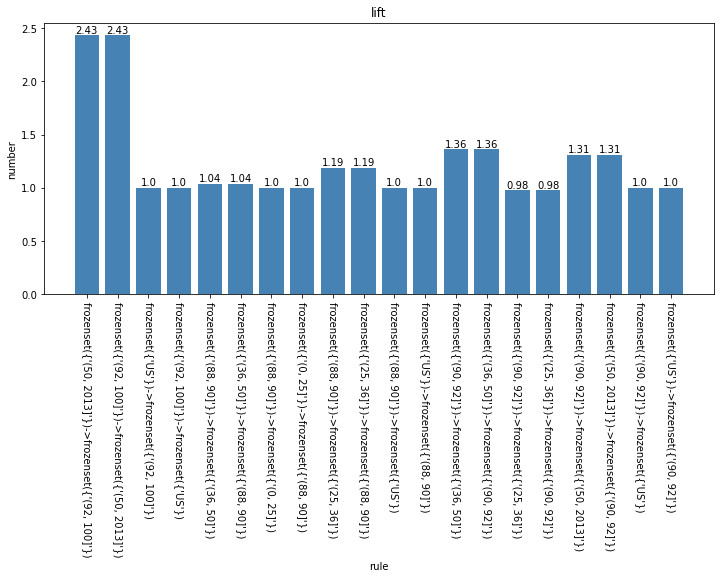

In [19]:
rule = []
lifts = []
for item in lift[:20]:
    rule.append(str(item[0])+"->"+str(item[1]))
    lifts.append(round(item[2], 2))
show(rule,lifts,'lift','number')

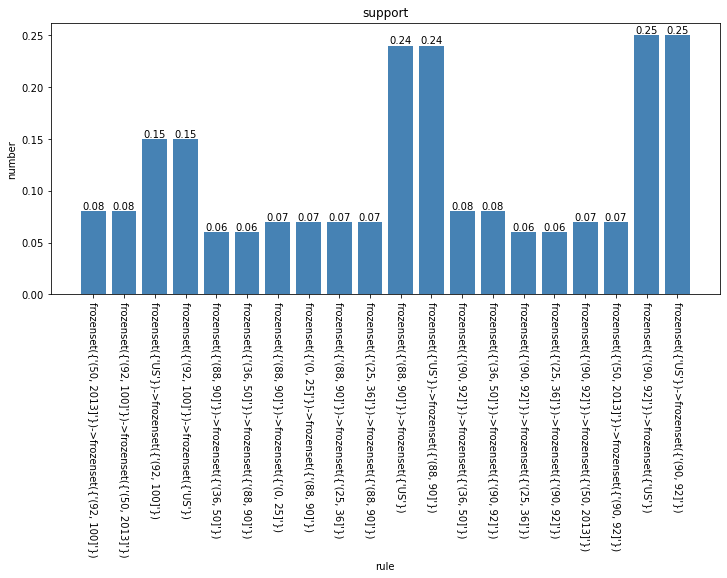

In [20]:
show(rule,sup,"support","number")

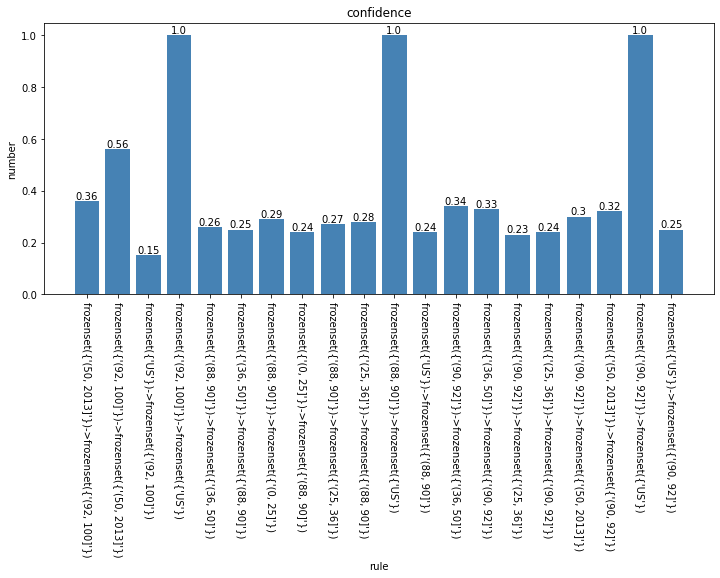

In [21]:
show(rule,conf,"confidence","number")

**分析**
- 规则‘US'->(88,90],US'->(90,92],‘US'->（92，100)的规则提升度最高，说明美国产的葡萄酒与三种评分正相关性高。
- （92，100)->'US,(88,90]->'US',(90,92]->'US'的置信度相对较高，即高度数酒较多产于美国。